Dataset Shape: (1118669, 34)


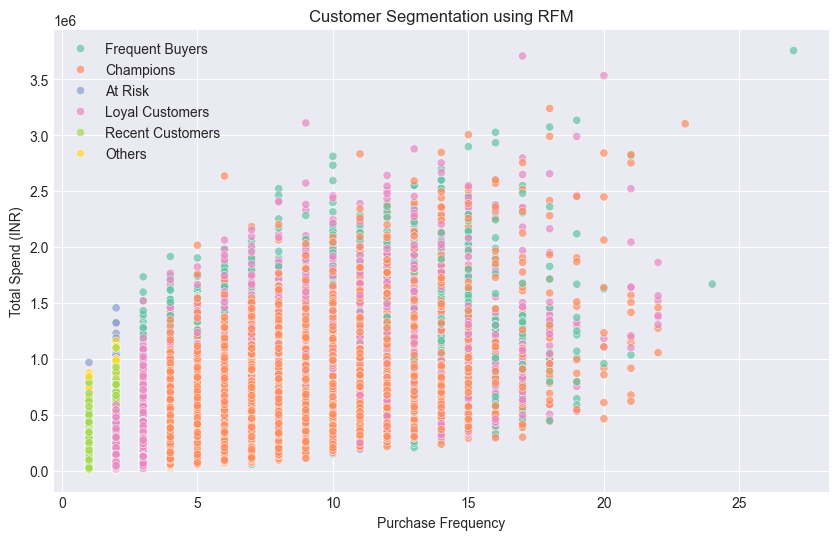

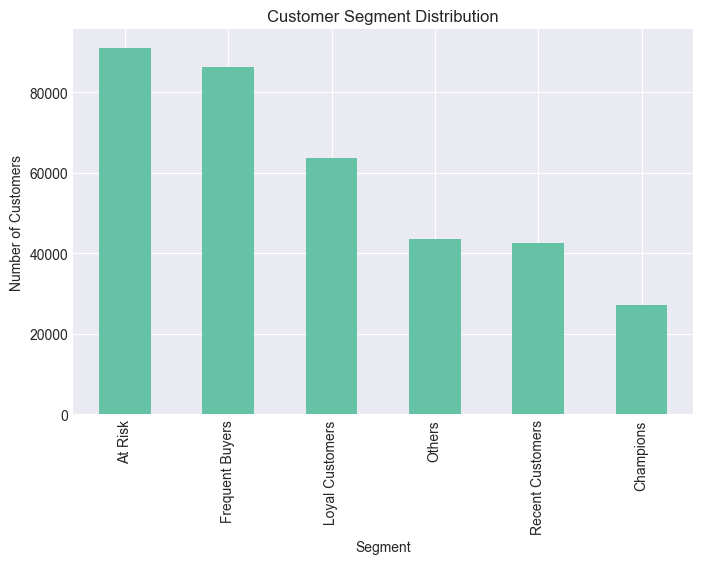

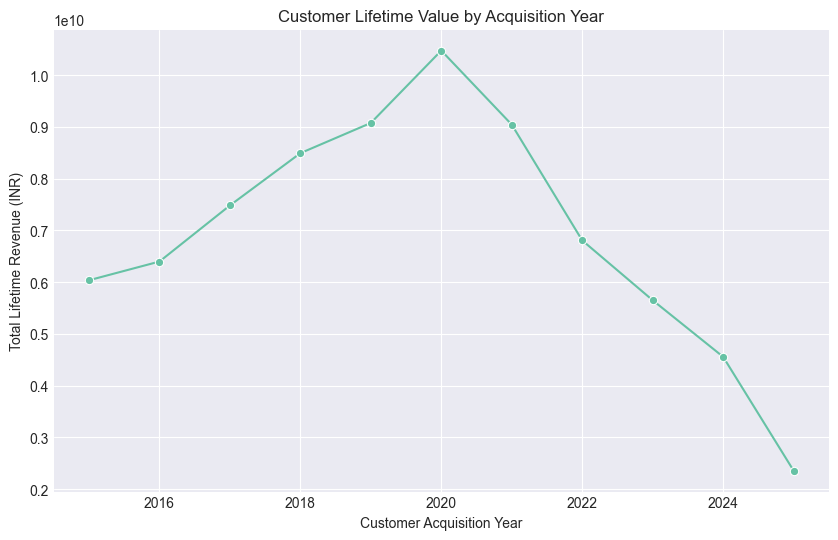

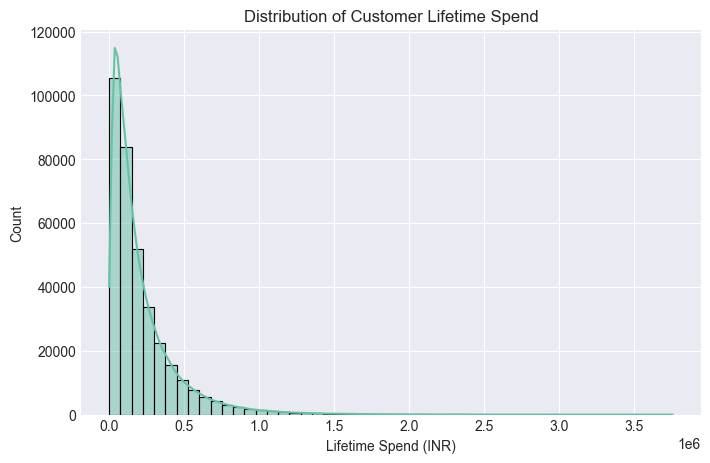


KEY INSIGHTS:
- Champions and Loyal Customers contribute the highest revenue
- At-Risk customers need retention strategies
- Earlier acquisition cohorts (2015–2018) have higher CLV
- Retention is more valuable than constant new acquisition



In [1]:
# ======================================================
# EDA 02: CUSTOMER SEGMENTATION & CLV ANALYSIS
# QUESTIONS COVERED:
# Q3  - RFM Customer Segmentation
# Q14 - Customer Lifetime Value (CLV)
# ======================================================

# ===============================
# IMPORT LIBRARIES
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("Set2")

# ===============================
# LOAD MASTER DATASET
# ===============================
FILE_PATH = "../master/amazon_india_master_2015_2025.csv"

df = pd.read_csv(FILE_PATH)
df["order_date"] = pd.to_datetime(df["order_date"])

print("Dataset Shape:", df.shape)
df.head()

# ======================================================
# QUESTION 3: RFM CUSTOMER SEGMENTATION
# ======================================================

# -------------------------------
# Step 1: Create RFM Metrics
# -------------------------------
snapshot_date = df["order_date"].max() + pd.Timedelta(days=1)

rfm = df.groupby("customer_id").agg({
    "order_date": lambda x: (snapshot_date - x.max()).days,  # Recency
    "transaction_id": "count",                                # Frequency
    "final_amount_inr": "sum"                                 # Monetary
}).reset_index()

rfm.columns = ["customer_id", "Recency", "Frequency", "Monetary"]

rfm.head()

# -------------------------------
# Step 2: RFM Scoring (Quartiles)
# -------------------------------
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) +
    rfm["F_Score"].astype(str) +
    rfm["M_Score"].astype(str)
)

rfm.head()

# -------------------------------
# Step 3: Define Customer Segments
# -------------------------------
def rfm_segment(row):
    if row["R_Score"] == 4 and row["F_Score"] == 4:
        return "Champions"
    if row["R_Score"] >= 3 and row["F_Score"] >= 3:
        return "Loyal Customers"
    if row["R_Score"] == 4:
        return "Recent Customers"
    if row["F_Score"] >= 3:
        return "Frequent Buyers"
    if row["R_Score"] <= 2 and row["F_Score"] <= 2:
        return "At Risk"
    return "Others"

rfm["Segment"] = rfm.apply(rfm_segment, axis=1)

rfm["Segment"].value_counts()

# -------------------------------
# Step 4: RFM Scatter Plot
# -------------------------------
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=rfm,
    x="Frequency",
    y="Monetary",
    hue="Segment",
    alpha=0.7
)

plt.title("Customer Segmentation using RFM")
plt.xlabel("Purchase Frequency")
plt.ylabel("Total Spend (INR)")
plt.legend()
plt.show()

# -------------------------------
# Step 5: Segment Distribution
# -------------------------------
plt.figure(figsize=(8, 5))

rfm["Segment"].value_counts().plot(kind="bar")

plt.title("Customer Segment Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()

# ======================================================
# QUESTION 14: CUSTOMER LIFETIME VALUE (CLV)
# ======================================================

# -------------------------------
# Step 6: Customer Cohort Creation
# -------------------------------
df["first_purchase_year"] = (
    df.groupby("customer_id")["order_date"].transform("min").dt.year
)

df["order_year"] = df["order_date"].dt.year

df[["customer_id", "first_purchase_year", "order_year"]].head()

# -------------------------------
# Step 7: Cohort Revenue Table
# -------------------------------
cohort_revenue = (
    df.groupby(["first_purchase_year", "order_year"])
      .agg({"final_amount_inr": "sum"})
      .reset_index()
)

cohort_revenue.head()

# -------------------------------
# Step 8: CLV by Acquisition Year
# -------------------------------
clv = (
    cohort_revenue
    .groupby("first_purchase_year")["final_amount_inr"]
    .sum()
    .reset_index()
)

clv.columns = ["Acquisition_Year", "Customer_Lifetime_Value"]

clv

# -------------------------------
# Step 9: CLV Trend Visualization
# -------------------------------
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=clv,
    x="Acquisition_Year",
    y="Customer_Lifetime_Value",
    marker="o"
)

plt.title("Customer Lifetime Value by Acquisition Year")
plt.xlabel("Customer Acquisition Year")
plt.ylabel("Total Lifetime Revenue (INR)")
plt.show()

# -------------------------------
# Step 10: CLV Distribution
# -------------------------------
plt.figure(figsize=(8, 5))

sns.histplot(
    rfm["Monetary"],
    bins=50,
    kde=True
)

plt.title("Distribution of Customer Lifetime Spend")
plt.xlabel("Lifetime Spend (INR)")
plt.show()

# ======================================================
# BUSINESS INSIGHTS SUMMARY
# ======================================================
print("""
KEY INSIGHTS:
- Champions and Loyal Customers contribute the highest revenue
- At-Risk customers need retention strategies
- Earlier acquisition cohorts (2015–2018) have higher CLV
- Retention is more valuable than constant new acquisition
""")
